In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from readability import Readability
from itertools import combinations
import glob
import yake
from tqdm import tqdm
from scipy.stats import pearsonr
from collections import defaultdict
from sklearn.metrics import cohen_kappa_score
import os

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /scratch4/mdredze1/nltk_cache...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /scratch4/mdredze1/nltk_cache...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
output_dir = os.environ.get('READABILITY_ANALYSIS_DATA_DIR')
dataset_dir = os.environ.get('DATASET_DIR')

In [3]:
output_files = glob.glob(f"{output_dir}/meta-llama/Llama-3.3-70B-Instruct*.csv")
len(output_files)

10

In [4]:
def get_summaries(d_name):
    f_name = f'{dataset_dir}/{d_name}.target'
    lines = open(f_name).readlines()
    return [l.strip() for l in lines]

In [5]:
def get_scores(files_list):
    objs = []
    for f_name in files_list:
        df = pd.read_csv(f_name)
        try:
            scores = df['reading_ease'].to_list()
            responses = df['response'].to_list()
            reasons = df['reason'].to_list()
            dataset = f_name.split('.')[-2]
            summaries = get_summaries(dataset)
            model = f_name.split('.')[-3]
            objs.append(
                pd.DataFrame.from_dict(
                    {
                    'readability': scores, 
                    'summary': summaries,
                    'response': responses, 
                    'reason': reasons,
                    'dataset': dataset, 
                    'model': model})
            )
        except KeyError:
            print(f_name)
    return pd.concat(axis=0, ignore_index=True, objs=objs)
all_scores = get_scores(output_files)
all_scores

,readability,summary,response,reason,dataset,model
0,3,Influenza virus continues to pose a significan...,"[{'role': 'assistant', 'content': 'Score: 3\nR...",The text assumes some basic knowledge of biolo...,plos,3-70B-Instruct-own_reasoning
1,2,"In Brazil , leprosy remains a significant publ...","[{'role': 'assistant', 'content': 'Score: 2\nR...",The text assumes a significant amount of backg...,plos,3-70B-Instruct-own_reasoning
2,2,Leishmaniasis is a tropical disease transmitte...,"[{'role': 'assistant', 'content': 'Score: 2\nR...",The text assumes a high level of background kn...,plos,3-70B-Instruct-own_reasoning
3,2,We address how predictable evolution is at the...,"[{'role': 'assistant', 'content': 'Score: 2\nR...",The text assumes a high level of background kn...,plos,3-70B-Instruct-own_reasoning
4,2,Certain proteins can occasionally misfold into...,"[{'role': 'assistant', 'content': 'Score: 2\nR...",The text assumes a significant amount of backg...,plos,3-70B-Instruct-own_reasoning
...,...,...,...,...,...,...
27173,3,What catches our eye We are almost constantly ...,"[{'role': 'assistant', 'content': 'Score: 3\nR...",The text assumes a basic understanding of biol...,eureka,3-70B-Instruct-own_reasoning
27174,3,Molecule capable of halting and reverting Park...,"[{'role': 'assistant', 'content': 'Score: 3\nR...",The text assumes some basic knowledge of biolo...,eureka,3-70B-Instruct-own_reasoning
27175,4,Is the key to sparking climate action a game ?...,"[{'role': 'assistant', 'content': 'Score: 4\nR...",The text is well-structured and written in a c...,eureka,3-70B-Instruct-own_reasoning
27176,2,Jumping genes drive sex chromosome changes in ...,"[{'role': 'assistant', 'content': 'Score: 2\nR...",The text assumes a significant amount of backg...,eureka,3-70B-Instruct-own_reasoning


In [6]:
def get_readability(text):
  try:
    r = Readability(text, min_words=4)
    return r.flesch_kincaid().score
  except Exception as e:
    return -1
r = Readability("This is a test sentence.", min_words=4)
r.flesch_kincaid().score

/home/icachol1/py-readability-metrics/readability/readability.py:12: UserWarning: Documents with fewer than 100 words may affect the accuracy of readability tests
  warnings.warn(


0.46999999999999886

In [7]:
all_scores['fkgl'] = all_scores['summary'].apply(get_readability)

In [8]:
def get_aggreement_from_binary(r_level, lm_level):
    try:
        tmp = all_scores[all_scores['fkgl'] != -1]
        fkglbinary = tmp['fkgl'] < r_level
        lm_binary = tmp['readability'] >= lm_level
        tmp['fkglbinary'] = fkglbinary.apply(int)
        tmp['lm_binary'] = lm_binary.apply(int)
        print(f"{sum(tmp['fkglbinary'] == tmp['lm_binary'])} / {len(tmp)}")
        return cohen_kappa_score(tmp['fkglbinary'], tmp['lm_binary'])
    except:
    
        return -10000
get_aggreement_from_binary(16, 3)

14944 / 27176


/tmp/ipykernel_1670443/4266298086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['fkglbinary'] = fkglbinary.apply(int)
/tmp/ipykernel_1670443/4266298086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['lm_binary'] = lm_binary.apply(int)


np.float64(0.16684697684830097)

## Keyword Analysis

In [9]:
stops = set(stopwords.words('english'))
def get_keywords(text, n=4, dedupLim=3.0):
    kw_extractor = yake.KeywordExtractor(lan="en", n=n, dedupLim=dedupLim, top=10, features=None, stopwords=stops)
    keywords = kw_extractor.extract_keywords(text)
    return [k[1] for k in keywords]

In [10]:
def get_txt(d_name):
    tmp = all_scores[all_scores['dataset']==d_name]
    text = '\n'.join(tmp['reason']).lower()
    print(len(text))
    return text

In [11]:
def get_txt_by_score(score):
    tmp = all_scores[all_scores['readability']==score]
    tmp = tmp.dropna(subset=['reason'])
    text = '\n'.join(tmp['reason']).lower()
    return text

In [46]:
print(', '.join(get_keywords(get_txt_by_score(1), n=3, dedupLim=1.0)))

expert background knowledge, strong background knowledge, text also assumes, text requires expert, background knowledge, highly technical, text assumes, text also, text also includes, text


In [13]:
print(', '.join(get_keywords(get_txt_by_score(2), n=3, dedupLim=2.0)))

text assumes, background knowledge, using technical terms, text discusses complex, strong background knowledge, require specialized knowledge, using specialized terms, technical terms like, requires specialized knowledge, text


In [48]:
print(', '.join(get_keywords(get_txt_by_score(3),  n=4, dedupLim=2.0)))

understandable for a general, adults with some medical, terms are not highly, concepts and the sentence, making it a challenging, readable with some basic, understandable for the general, audience than just medical, clear to a general, vocabulary of the text


In [15]:
print(', '.join(get_keywords(get_txt_by_score(4))))

explanation for the non-expert, understanding are the use, context in a clear, explanations for the non-expert, terms for a non-expert, terms for those without, understanding are the medical, familiarity with these concepts, understandable for some readers, topic itself is specialized


In [16]:
print(', '.join(get_keywords(get_txt_by_score(5))))

concepts in an accessible, language that is easy, text to be accessible, easy for a general, concepts that are easy, text uses simple language, text uses simple, text also uses relatable, text also uses, text


### keywords by dataset

In [17]:
arxiv = get_txt('arxiv')
print(', '.join(get_keywords(arxiv)))

4133804
familiar with the specific, expertise in this area, research in a specialized, vocabulary and the specialized, suggests that a significant, matter and is likely, likely for an academic, sentences and the use, understand for an adult, readers with some expertise


In [18]:
pubmed = get_txt('pubmed')
print(', '.join(get_keywords(pubmed)))

4522916
knowledge about the disease, accessible than a highly, indicating that some readers, understanding of its content, background or some familiarity, structure of a scientific, rather than being highly, methods that are likely, professionals with a strong, concepts such as molecular


In [19]:
skj = get_txt('skj')
print(', '.join(get_keywords(skj)))

161821
easy for most adults, understand for most adults, understand for an adult, straightforward and the concepts, easy for an adult, understand for most adult, readers with a basic, reader with a basic, population with some basic, concepts in a clear


In [50]:
cdsr = get_txt('cdsr')
print(', '.join(get_keywords(cdsr)))

36744
text, text assumes some basic, text assumes, basic knowledge, assumes some basic knowledge, basic knowledge of medical, knowledge, general adult audience, medical, background knowledge


In [21]:
scitldr = get_txt('scitldr')
', '.join(get_keywords(scitldr))

296661


'terms or the context, context for these terms, specific to these fields, intended for a general, audience with some general, audience with some technical, networks and the concept, fields such as artificial, likely from the field, audience with some background'

In [53]:
plos = get_txt('plos')
print(', '.join(get_keywords(plos, n=3, dedupLim=2.0)))

928214
text assumes, background knowledge, text discusses complex, text, using technical terms, require specialized knowledge, strong background knowledge, specialized knowledge, knowledge, discusses complex concepts


In [51]:
eureka = get_txt('eureka')
print(', '.join(get_keywords(eureka, n=3, dedupLim=2.0)))

766651
general adult audience, text assumes, text, background knowledge, basic knowledge, require specialized knowledge, require expert-level knowledge, knowledge, text may require, may require


In [24]:
elife = get_txt('elife')
print(', '.join(get_keywords(elife)))

172378
readers with a background, explanation for the technical, explanation of the concepts, explanation for the concepts, understand for a general, explanations for the technical, audience with a background, explanation of these concepts, understanding of the concepts, without such a background


In [25]:
cells = get_txt('cells')
print(', '.join(get_keywords(cells)))

4117628
adult with no expert, audience with no science, familiar with the concept, topic itself is specialized, familiar with the general, matter and the level, topic is a specialized, foundation in these fields, readers with some scientific, reader with some scientific


In [26]:
scinews = get_txt('scinews')
print(', '.join(get_keywords(scinews)))

3191243
understandable by those without, knowledge of a specific, field and its use, understand all the details, includes a few specialized, knowledge of the academic, make it more readable, understanding of these fields, concepts to a level, unfamiliar to those without


# Scores analysis

In [28]:
all_scores.groupby('dataset')['fkgl'].mean()

dataset
arxiv      14.828584
cdsr       14.084669
cells      16.470050
elife      11.869979
eureka     14.987506
plos       15.789545
pubmed     16.680985
scinews    14.983279
scitldr    15.661621
skj         8.957463
Name: fkgl, dtype: float64

In [27]:
all_scores.groupby('dataset')['readability'].mean()

dataset
arxiv      1.313354
cdsr       3.490566
cells      2.230867
elife      3.178423
eureka     3.214851
plos       2.061773
pubmed     1.992038
scinews    3.370821
scitldr    1.855987
skj        4.401408
Name: readability, dtype: float64

In [29]:
all_scores.groupby('dataset')['readability'].median()

dataset
arxiv      1.0
cdsr       4.0
cells      2.0
elife      3.0
eureka     3.0
plos       2.0
pubmed     2.0
scinews    4.0
scitldr    2.0
skj        4.0
Name: readability, dtype: float64

In [30]:
all_scores.groupby('dataset')['readability'].var()

dataset
arxiv      0.229795
cdsr       0.523948
cells      0.504061
elife      0.647199
eureka     0.666380
plos       0.260181
pubmed     0.187587
scinews    0.637477
scitldr    0.324445
skj        0.241129
Name: readability, dtype: float64

In [31]:
all_scores.groupby('dataset')['readability'].value_counts()

dataset  readability
arxiv    1              4464
         2              1939
         3                32
         4                 5
cdsr     4                33
         3                13
         2                 7
cells    2              4675
         4               627
         3               606
         1               403
elife    4               103
         3                78
         2                60
eureka   4               467
         3               294
         2               248
         1                 1
plos     2              1145
         1                95
         3                92
         4                44
pubmed   2              5738
         1               541
         3               268
         4               110
scinews  4              2390
         3               970
         2               819
         1                 9
scitldr  2               456
         1               134
         4                17
         3            

In [32]:
all_scores['dataset'].value_counts()

dataset
pubmed     6657
arxiv      6440
cells      6311
scinews    4188
plos       1376
eureka     1010
scitldr     618
skj         284
elife       241
cdsr         53
Name: count, dtype: int64

In [33]:
all_scores['readability'] = all_scores['readability'].round()
tmp = all_scores.groupby('dataset')['readability'].value_counts().to_frame()
tmp = tmp.pivot_table(values="count", columns="dataset",index="readability")
tmp.fillna(0, inplace=True)
tmp

dataset,arxiv,cdsr,cells,elife,eureka,plos,pubmed,scinews,scitldr,skj
readability,,,,,,,,,,
1,4464.0,0.0,403.0,0.0,1.0,95.0,541.0,9.0,134.0,0.0
2,1939.0,7.0,4675.0,60.0,248.0,1145.0,5738.0,819.0,456.0,0.0
3,32.0,13.0,606.0,78.0,294.0,92.0,268.0,970.0,11.0,0.0
4,5.0,33.0,627.0,103.0,467.0,44.0,110.0,2390.0,17.0,170.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.0


In [34]:
tmp.to_csv(f"{output_dir}/readability_counts.csv")

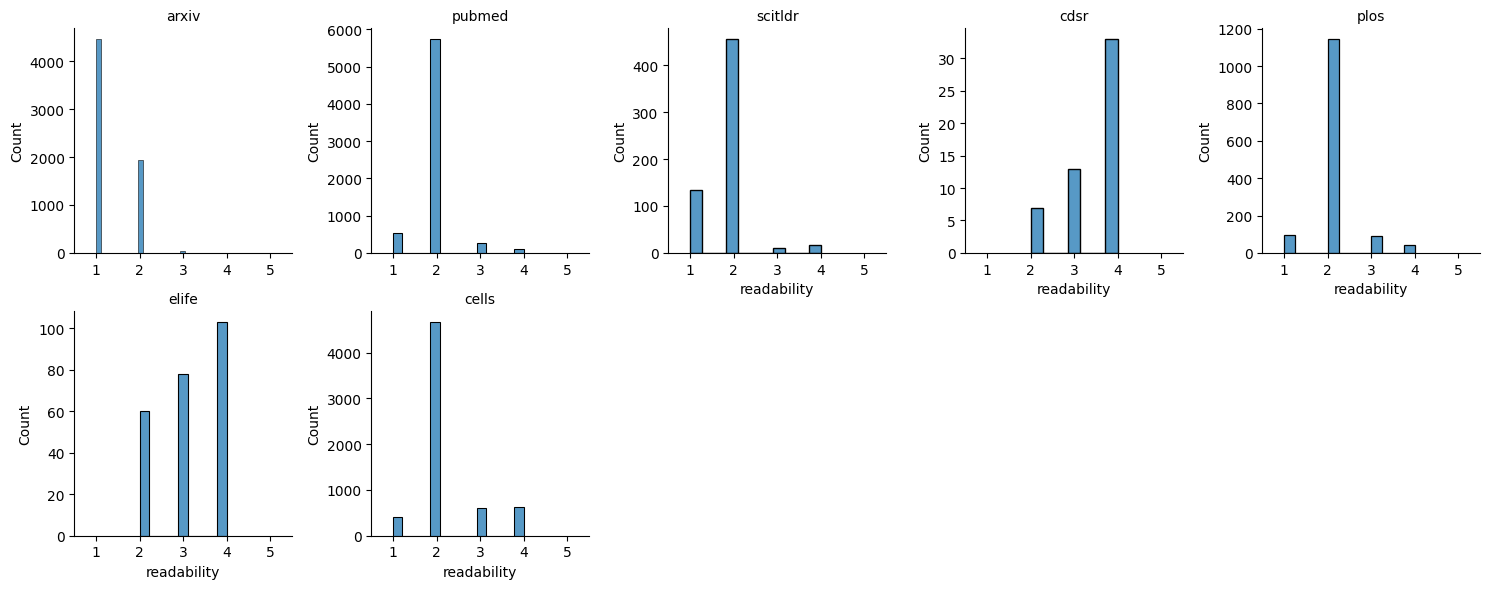

In [35]:
g = sns.FacetGrid(all_scores, 
                col="dataset", 
                col_order=[
                    "arxiv", 
                    "pubmed", 
                    "scitldr",
                    "cdsr", 
                    "plos", 
                    "elife", 
                    "cells", 
                    ],
                sharey=False, 
                sharex=False, 
                xlim=(0.5,5.5), 
                col_wrap=5
                )

# Map the histplot function to each subplot
g.map(sns.histplot, "readability")

# g.refline(x=all_scores["readability"].mean())
g.set_titles(col_template="{col_name}")
# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [36]:
summaries_files = glob.glob(f"{dataset_dir}/targets/*.target")

In [37]:
format_str = """\
Mean: {:0.2f}
Median: {:0.0f}
Max: {:0.0f}
Min: {:0.0f}
Var:{:0.2f}
"""

def get_len(text):
    return len(text.strip().split())

def analyze_texts(texts, return_n_tokens=False):
    n_tokens = np.zeros(len(texts))
    for i, t in enumerate(texts):
        n_tokens[i] = get_len(t)
    if return_n_tokens:
        return n_tokens
    return [np.mean(n_tokens),
        np.median(n_tokens),
        np.max(n_tokens),
        np.min(n_tokens),
        np.var(n_tokens)]
        
def analyze_file(fpath, return_n_tokens=False):
    with open(fpath) as f:
        texts = f.readlines()
    return analyze_texts(texts, return_n_tokens)

In [38]:
col_names = ["dataset", "mean", "median", "max", "min", "var"]
rows = []
for f_name in summaries_files:
    dataset_name = f_name.split('/')[-1].split('.')[-2]
    stats = analyze_file(f_name)
    rows.append([dataset_name]+stats)

df = pd.DataFrame(rows, columns=col_names)
df


,dataset,mean,median,max,min,var


In [39]:
all_scores[all_scores['dataset'] == 'scinews']

,readability,summary,response,reason,dataset,model,fkgl
14652,2,An international team of researchers with key ...,"[{'role': 'assistant', 'content': 'Score: 2\nR...",The text assumes a significant amount of backg...,scinews,3-70B-Instruct-own_reasoning,13.518761
14653,4,Exposure to antibiotics in the first days of l...,"[{'role': 'assistant', 'content': 'Score: 4\nR...",The text assumes some basic knowledge of medic...,scinews,3-70B-Instruct-own_reasoning,15.670000
14654,3,An ancient biological enzyme known as nickel-i...,"[{'role': 'assistant', 'content': 'Score: 3\nR...",The text assumes a basic understanding of chem...,scinews,3-70B-Instruct-own_reasoning,16.319851
14655,4,Older people who experience significant weight...,"[{'role': 'assistant', 'content': ""Score: 4\nR...",The text assumes some basic knowledge of healt...,scinews,3-70B-Instruct-own_reasoning,14.629856
14656,3,An international study led by the University C...,"[{'role': 'assistant', 'content': 'Score: 3\nR...",The text assumes a basic understanding of scie...,scinews,3-70B-Instruct-own_reasoning,18.882038
...,...,...,...,...,...,...,...
18835,3,A key technical challenge in creating new sulf...,"[{'role': 'assistant', 'content': 'Score: 3\nR...",The text assumes a basic understanding of chem...,scinews,3-70B-Instruct-own_reasoning,15.326073
18836,3,Increased carbon sequestration in soil to help...,"[{'role': 'assistant', 'content': 'Score: 3\nR...",The text assumes a basic understanding of envi...,scinews,3-70B-Instruct-own_reasoning,19.410183
18837,4,Medicines such as insulin for diabetes and clo...,"[{'role': 'assistant', 'content': 'Score: 4\nR...",The text assumes some basic knowledge of biolo...,scinews,3-70B-Instruct-own_reasoning,15.417826
18838,2,The electronic structure of nonmagnetic crysta...,"[{'role': 'assistant', 'content': 'Score: 2\nR...",The text is written in a highly technical and ...,scinews,3-70B-Instruct-own_reasoning,18.658486


In [40]:
all_scores['n_tokens'] = -1
for fpath in summaries_files:
    print(fpath)
    dataset_name = fpath.split('/')[-1].split('.')[-2]
    print(dataset_name)
    ntokens  = analyze_file(fpath, return_n_tokens=True)
    print(len(ntokens))
    print(all_scores[all_scores['dataset'] == dataset_name].shape)
    all_scores.loc[all_scores['dataset'] == dataset_name, 'n_tokens'] = ntokens
all_scores

,readability,summary,response,reason,dataset,model,fkgl,n_tokens
0,3,Influenza virus continues to pose a significan...,"[{'role': 'assistant', 'content': 'Score: 3\nR...",The text assumes some basic knowledge of biolo...,plos,3-70B-Instruct-own_reasoning,17.605695,-1
1,2,"In Brazil , leprosy remains a significant publ...","[{'role': 'assistant', 'content': 'Score: 2\nR...",The text assumes a significant amount of backg...,plos,3-70B-Instruct-own_reasoning,14.050317,-1
2,2,Leishmaniasis is a tropical disease transmitte...,"[{'role': 'assistant', 'content': 'Score: 2\nR...",The text assumes a high level of background kn...,plos,3-70B-Instruct-own_reasoning,16.067775,-1
3,2,We address how predictable evolution is at the...,"[{'role': 'assistant', 'content': 'Score: 2\nR...",The text assumes a high level of background kn...,plos,3-70B-Instruct-own_reasoning,16.174775,-1
4,2,Certain proteins can occasionally misfold into...,"[{'role': 'assistant', 'content': 'Score: 2\nR...",The text assumes a significant amount of backg...,plos,3-70B-Instruct-own_reasoning,12.233793,-1
...,...,...,...,...,...,...,...,...
27173,3,What catches our eye We are almost constantly ...,"[{'role': 'assistant', 'content': 'Score: 3\nR...",The text assumes a basic understanding of biol...,eureka,3-70B-Instruct-own_reasoning,14.432601,-1
27174,3,Molecule capable of halting and reverting Park...,"[{'role': 'assistant', 'content': 'Score: 3\nR...",The text assumes some basic knowledge of biolo...,eureka,3-70B-Instruct-own_reasoning,22.507069,-1
27175,4,Is the key to sparking climate action a game ?...,"[{'role': 'assistant', 'content': 'Score: 4\nR...",The text is well-structured and written in a c...,eureka,3-70B-Instruct-own_reasoning,14.359478,-1
27176,2,Jumping genes drive sex chromosome changes in ...,"[{'role': 'assistant', 'content': 'Score: 2\nR...",The text assumes a significant amount of backg...,eureka,3-70B-Instruct-own_reasoning,15.777970,-1


In [41]:
all_scores['dataset'].value_counts()

dataset
pubmed     6657
arxiv      6440
cells      6311
scinews    4188
plos       1376
eureka     1010
scitldr     618
skj         284
elife       241
cdsr         53
Name: count, dtype: int64

In [42]:
pearsonr(all_scores['readability'], all_scores['n_tokens'])

/tmp/ipykernel_1670443/651468745.py:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(all_scores['readability'], all_scores['n_tokens'])


PearsonRResult(statistic=nan, pvalue=nan)

<Axes: xlabel='readability', ylabel='n_tokens'>

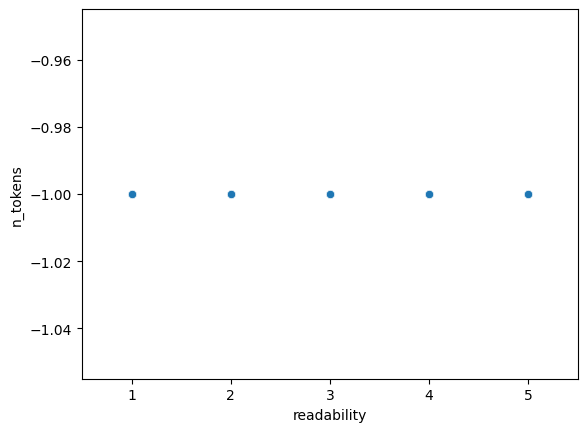

In [43]:
ax = plt.subplot()
ax.xaxis.set_ticks([1,2,3,4,5])
ax.set_xlim([0.5,5.5])
sns.scatterplot(all_scores, x="readability", y='n_tokens', ax=ax)